F1 forecasting - Data Science w Pythonie 2024

* Radosław Rybakowski 109174
* Zuzanna Dawid 89815
* Maciej Świderek 82701

## Data transformations

In [52]:
import pandas as pd
import datetime

In [53]:
pd.set_option('display.max_columns', None)

In [54]:
results = pd.read_csv(r"data/results.csv")
races = pd.read_csv(r"data/races.csv")
drivers = pd.read_csv(r"data/drivers.csv")
driver_standings = pd.read_csv(r"data/driver_standings.csv")
constructors = pd.read_csv(r"data/constructors.csv")
constructor_standings = pd.read_csv(r"data/constructor_standings.csv")
constructor_results = pd.read_csv(r"data/constructor_results.csv")
pit_stops = pd.read_csv(r"data/pit_stops.csv")
status = pd.read_csv(r"data/status.csv")
seasons = pd.read_csv(r"data/seasons.csv")

circuits = pd.read_csv(r"data/circuits.csv")
lap_times = pd.read_csv(r"data/lap_times.csv")
qualifying = pd.read_csv(r"data/qualifying.csv")
sprint_results = pd.read_csv(r"data/sprint_results.csv")

In [55]:
print('\nDrivers:')
print((drivers == "\\N").sum())
print('\nRaces:')
print((races == "\\N").sum())
print('\nResults:')
print((results == "\\N").sum())
print('\nConstructor_results:')
print((constructor_results == "\\N").sum())
print('\nQualifying:')
print((qualifying == "\\N").sum())
print('\nSprint_results:')
print((sprint_results == "\\N").sum())

# W pozostałych zbiorach nie ma pustych wartości:
# print((circuits == "\\N").sum())
# print((constructor_standings == "\\N").sum())
# print((constructors == "\\N").sum())
# print((driver_standings == "\\N").sum())
# print((lap_times == "\\N").sum())
# print((pit_stops == "\\N").sum())
# print((seasons == "\\N").sum())
# print((status == "\\N").sum())


Drivers:
driverId         0
driverRef        0
number         802
code           757
forename         0
surname          0
dob              0
nationality      0
url              0
dtype: int64

Races:
raceId            0
year              0
round             0
circuitId         0
name              0
date              0
time            731
url               0
fp1_date       1035
fp1_time       1057
fp2_date       1035
fp2_time       1057
fp3_date       1053
fp3_time       1072
quali_date     1035
quali_time     1057
sprint_date    1107
sprint_time    1110
dtype: int64

Results:
resultId               0
raceId                 0
driverId               0
constructorId          0
number                 6
grid                   0
position           10916
positionText           0
positionOrder          0
points                 0
laps                   0
time               18931
milliseconds       18931
fastestLap         18478
rank               18249
fastestLapTime     18478
fastestLapSpeed

In [56]:
# Stworzenie zmiennej z punktami/rankingiem teamu przed danym wyścigiem

constructor_standings = constructor_standings.sort_values(by='raceId')
constructor_standings['points_before'] = constructor_standings.groupby('constructorId')['points'].shift(1)
constructor_standings['ranking_before'] = constructor_standings.groupby('constructorId')['position'].shift(1)
constructor_standings.dropna(inplace=True)
constructor_standings['points_before']=constructor_standings['points_before'].astype(int)
constructor_standings['ranking_before']=constructor_standings['ranking_before'].astype(int)
constructor_standings = constructor_standings[['raceId','constructorId','points_before','ranking_before']]

In [57]:
constructor_standings

,raceId,constructorId,points_before,ranking_before
3676,2,9,0,8
3684,2,23,18,1
3682,2,7,11,2
3675,2,6,0,9
3680,2,3,3,4
...,...,...,...,...
13205,1126,117,40,5
13206,1126,15,0,10
13207,1126,210,5,7
13208,1126,215,7,6


In [58]:
# Stworzenie zmiennej z punktami/rankingiem kierowcy przed danym wyścigiem

driver_standings = driver_standings.sort_values(by='raceId')
driver_standings['points_before'] = driver_standings.groupby('driverId')['points'].shift(1)
driver_standings['ranking_before'] = driver_standings.groupby('driverId')['position'].shift(1)
driver_standings.dropna(inplace=True)
driver_standings['points_before']=driver_standings['points_before'].astype(int)
driver_standings['ranking_before']=driver_standings['ranking_before'].astype(int)

In [59]:
# Stworzenie zmiennej ze średnim czasem trwania pit-stopu w sezonie dla poszczególnych teamów

pit_stops_merged = pd.merge(pit_stops, results, on = ['driverId','raceId'], how = 'left')
pit_stops_merged = pd.merge(pit_stops_merged, races, on = ['raceId'], how = 'left')
pit_stops_merged = pit_stops_merged[['raceId','constructorId','duration','year']]
pit_stops_merged['duration'] = pd.to_numeric(pit_stops_merged['duration'], errors='coerce')
pit_stops_merged['avg_season_duration'] = pit_stops_merged.groupby(['constructorId', 'year'])['duration'].transform('mean')
pit_stops_merged = pit_stops_merged[['year','constructorId','avg_season_duration']]
pit_stops_merged = pit_stops_merged.drop_duplicates()

In [60]:
pit_stops_merged.loc[pit_stops_merged['year']==2024].sort_values(by='constructorId')

,year,constructorId,avg_season_duration
10578,2024,1,22.434800
10550,2024,3,23.691211
10552,2024,6,21.888706
10554,2024,9,22.328842
10547,2024,15,26.523905
10548,2024,117,22.919609
10551,2024,131,22.246316
10546,2024,210,23.899478
10549,2024,214,24.166955
10560,2024,215,22.021375


In [61]:
# Łączenie zbiorów i usuwanie niepotrzebnych/zduplikowanych kolumn

merged_df = pd.merge(results, status, on = 'statusId', how = 'left')
merged_df = pd.merge(merged_df, drivers, on = 'driverId', how = 'left')
merged_df = pd.merge(merged_df, races, on = 'raceId', how = 'left')
merged_df = pd.merge(merged_df, constructors, on = 'constructorId', how = 'left')
merged_df = pd.merge(merged_df, driver_standings, on = ['driverId','raceId'], how = 'left')
merged_df = pd.merge(merged_df, pit_stops_merged, on = ['year','constructorId'], how = 'left')
merged_df = pd.merge(merged_df, constructor_standings, on = ['raceId','constructorId'], how = 'left')
merged_df = merged_df.drop(['driverRef','number_y','number_x','code','dob','nationality_x','url_x','round'
                            ,'time_y','url_y','constructorRef','nationality_y','url','fp1_date'
                           ,'fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date'
                           ,'quali_time','sprint_date','sprint_time','position_x','fastestLap'
                           ,'fastestLapTime','rank','fastestLapSpeed','driverStandingsId'
                             ,'points_y','position_y','positionText_y','wins'], axis = 1)

In [62]:
# Uporządkowanie kolumn i zmiana nazw
order = ['resultId','raceId','name_x','year','date','driverId','forename','surname','constructorId','name_y','avg_season_duration','grid'
        ,'positionText_x','positionOrder','points_x','points_before_x','ranking_before_x','points_before_y','ranking_before_y','laps','time_x','milliseconds'
        ,'statusId','status','circuitId']
merged_df = merged_df[order]
merged_df = merged_df.rename(columns={'name_x':'race_name','date':'race_date','name_y':'constructor_name','grid':'start_position'
                                     ,'time_x':'time','rank':'fastest_lap_rank','positionOrder':'end_position','points_before_x':'driver_ranking_points_before_race'
                                     ,'ranking_before_x':'driver_ranking_before_race','positionText_x':'end_positionText','points_x':'points','avg_season_duration':'avg_season_pit_stop_duration'
                                     ,'ranking_before_y':'constructor_ranking_before_race','points_before_y':'constructor_ranking_points_before_race'})

In [63]:
(merged_df == "\\N").sum()

resultId                                      0
raceId                                        0
race_name                                     0
year                                          0
race_date                                     0
driverId                                      0
forename                                      0
surname                                       0
constructorId                                 0
constructor_name                              0
avg_season_pit_stop_duration                  0
start_position                                0
end_positionText                              0
end_position                                  0
points                                        0
driver_ranking_points_before_race             0
driver_ranking_before_race                    0
constructor_ranking_points_before_race        0
constructor_ranking_before_race               0
laps                                          0
time                                    

In [64]:
merged_df['status'].value_counts()
# Można pomyśleć czy bierzemy tylko Finished

status
Finished          7463
+1 Lap            3944
Engine            2022
+2 Laps           1600
Accident          1057
                  ... 
Launch control       1
Tyre puncture        1
+26 Laps             1
CV joint             1
Crankshaft           1
Name: count, Length: 137, dtype: int64

In [65]:
merged_df = merged_df.loc[merged_df['status']=='Finished']
merged_df = merged_df.loc[merged_df['year']>=2014]
merged_df = merged_df.loc[merged_df['start_position']!=0] #
merged_df.dropna(inplace=True)
merged_df['driver_ranking_points_before_race'] = merged_df['driver_ranking_points_before_race'].astype(int)
merged_df['driver_ranking_before_race'] = merged_df['driver_ranking_before_race'].astype(int)
merged_df['constructor_ranking_points_before_race'] = merged_df['constructor_ranking_points_before_race'].astype(int)
merged_df['constructor_ranking_before_race'] = merged_df['constructor_ranking_before_race'].astype(int)
(merged_df == "\\N").sum()

resultId                                  0
raceId                                    0
race_name                                 0
year                                      0
race_date                                 0
driverId                                  0
forename                                  0
surname                                   0
constructorId                             0
constructor_name                          0
avg_season_pit_stop_duration              0
start_position                            0
end_positionText                          0
end_position                              0
points                                    0
driver_ranking_points_before_race         0
driver_ranking_before_race                0
constructor_ranking_points_before_race    0
constructor_ranking_before_race           0
laps                                      0
time                                      0
milliseconds                              0
statusId                        

In [66]:
# for col in merged_df.columns:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 22127 to 26397
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   resultId                                2157 non-null   int64  
 1   raceId                                  2157 non-null   int64  
 2   race_name                               2157 non-null   object 
 3   year                                    2157 non-null   int64  
 4   race_date                               2157 non-null   object 
 5   driverId                                2157 non-null   int64  
 6   forename                                2157 non-null   object 
 7   surname                                 2157 non-null   object 
 8   constructorId                           2157 non-null   int64  
 9   constructor_name                        2157 non-null   object 
 10  avg_season_pit_stop_duration            2157 non-null   floa

### Some transform for modelling

In [67]:
model_df = merged_df.drop(["forename","status","end_positionText", "status", "statusId", "laps"], axis = 1).copy()
# constructor_ranking_points_before_race, driver_ranking_points_before_race - to transform

# model_df["constructor_ranking_points_before_race_mean"] =  model_df.groupby("raceId")["constructor_ranking_points_before_race"].mean()
model_df["constructor_ranking_points_before_race_mean"] = model_df.groupby("raceId")["constructor_ranking_points_before_race"].transform('mean')
model_df["constructor_ranking_points_before_race_relative"] = model_df["constructor_ranking_points_before_race"] - model_df["constructor_ranking_points_before_race_mean"]
model_df["constructor_ranking_points_before_race_relative"].describe()



count    2.157000e+03
mean    -7.642370e-16
std      1.348958e+02
min     -4.010000e+02
25%     -8.015385e+01
50%     -1.635294e+01
75%      5.811111e+01
max      5.692941e+02
Name: constructor_ranking_points_before_race_relative, dtype: float64

In [68]:
model_df["driver_ranking_points_before_race_mean"] = model_df.groupby("raceId")["driver_ranking_points_before_race"].transform('mean')
model_df["driver_ranking_points_before_race_relative"] = model_df["driver_ranking_points_before_race"] - model_df["driver_ranking_points_before_race_mean"]
model_df["driver_ranking_points_before_race_relative"].describe()

count    2.157000e+03
mean    -6.061190e-16
std      7.194303e+01
min     -1.808333e+02
25%     -4.273333e+01
50%     -9.285714e+00
75%      2.725000e+01
max      4.230588e+02
Name: driver_ranking_points_before_race_relative, dtype: float64

In [69]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the data within each group
model_df["constructor_rp_rel_std"] = scaler.fit_transform(model_df["constructor_ranking_points_before_race_relative"].values.reshape(-1, 1))
model_df["driver_rp_rel_std"] = scaler.fit_transform(model_df["driver_ranking_points_before_race_relative"].values.reshape(-1, 1))

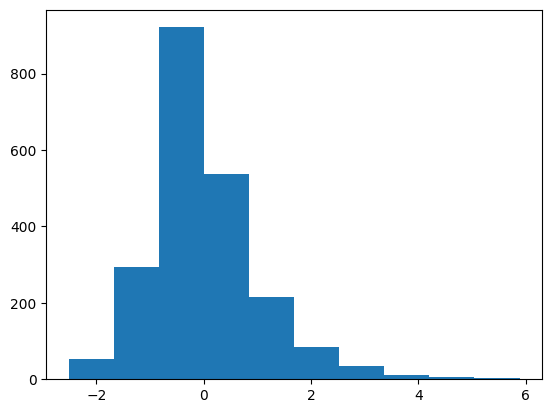

In [70]:
from matplotlib import pyplot as plt

plt.hist(model_df["driver_rp_rel_std"])
plt.show()

In [71]:
cols = ['race_name', 'constructor_name', "start_position", "constructor_ranking_before_race", "driver_ranking_before_race"]

for col in cols:
    model_df[col] = model_df[col].astype(str)
    if col == "start_position":
        model_df[col] = model_df[col].apply(lambda x: "start_position" + "_" + x)
    elif col == "constructor_ranking_before_race":
        model_df[col] = model_df[col].apply(lambda x: "constructor_rank" + "_" + x)
    elif col == "driver_ranking_before_race":
        model_df[col] = model_df[col].apply(lambda x: "driver_rank" + "_" +  x)
    model_df[col] = model_df[col].str.strip().str.lower()
    model_df[col] = model_df[col].apply(lambda name: name.replace(' ', '_'))
    # Use get_dummies to convert categorical variable into dummy/indicator variables
    dummy_model_df = pd.get_dummies(model_df[col]).astype(int)
    dummies = dummy_model_df.columns
    if col in ["race_name", "constructor_name"]:
        print(True)
        for dd in dummies:
            new_name = "trend_" + dd
            dummy_model_df[new_name] = scaler.fit_transform((model_df["raceId"]*dummy_model_df[dd]).values.reshape(-1, 1))
    # Concatenate the dummy variables with the original DataFrame
    model_df = pd.concat([model_df, dummy_model_df], axis=1)

True
True


In [72]:
model_df["race_date"] = pd.to_datetime(model_df["race_date"]) 
model_df["day"] = model_df["race_date"].dt.day_of_year
model_df["day"]

22127     75
22129     75
22130     75
22131     75
22132     75
        ... 
26393    126
26394    126
26395    126
26396    126
26397    126
Name: day, Length: 2157, dtype: int32

In [73]:


model_df.drop(["constructor_ranking_points_before_race_mean", 
               "constructor_ranking_points_before_race_relative", 
               "driver_ranking_points_before_race_mean",
               "driver_ranking_points_before_race_relative",
               "constructor_ranking_points_before_race",
               "driver_ranking_points_before_race",
               "constructor_ranking_before_race", 
               "driver_ranking_before_race",
               "constructorId",
               "points",
               "driverId",
               "circuitId",
               "race_name",
               'constructor_name',
               'start_position',
               "resultId",
               "milliseconds"], axis = 1, inplace = True)



merged_df

In [74]:
model_df.iloc[:,0:20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2157 entries, 22127 to 26397
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   raceId                        2157 non-null   int64         
 1   year                          2157 non-null   int64         
 2   race_date                     2157 non-null   datetime64[ns]
 3   surname                       2157 non-null   object        
 4   avg_season_pit_stop_duration  2157 non-null   float64       
 5   end_position                  2157 non-null   int64         
 6   time                          2157 non-null   object        
 7   constructor_rp_rel_std        2157 non-null   float64       
 8   driver_rp_rel_std             2157 non-null   float64       
 9   70th_anniversary_grand_prix   2157 non-null   int32         
 10  abu_dhabi_grand_prix          2157 non-null   int32         
 11  australian_grand_prix         

In [75]:
model_df["time2"] = model_df["time"].astype(str)
model_df["time2"]= model_df.apply(lambda x: "0" if (":" in x["time"]) & (x["end_position"] == 1) else x["time"], axis = 1)
model_df["time2"]= model_df["time2"].apply(lambda name: name.replace('+', ''))
model_df[["minutes","seconds"]]= model_df["time2"].str.split(':', expand=True)
model_df["seconds"] = model_df.apply(lambda x: x["minutes"] if "." in x["minutes"] else x["seconds"], axis = 1)
model_df["seconds"] = model_df.apply(lambda x: "0" if x["seconds"] is None else x["seconds"], axis = 1)
model_df["minutes"] = model_df.apply(lambda x: "0" if x["minutes"] == x["seconds"] else x["minutes"], axis = 1)
model_df["minutes"] = model_df.apply(lambda x: "0" if x["minutes"] == x["seconds"] else x["minutes"], axis = 1)
model_df["time2"]= model_df["seconds"].astype(float)
model_df["time"] = model_df["time2"] + model_df["minutes"].astype(float)*60

In [76]:
model_df["avg_season_pit_stop_duration"] = scaler.fit_transform(model_df["avg_season_pit_stop_duration"].values.reshape(-1, 1))

In [77]:

model_df.drop(["time2",
               "seconds",
               "minutes"], axis = 1, inplace = True)

In [78]:
# model_df.to_excel("model_df.xlsx")

In [79]:
# prediction_df = model_df[model_df["raceId"] == max(model_df["raceId"])] 
# prediction_df.to_excel("prediction_df.xlsx")

## XGBoost to predict formula one 

In [80]:
from xgboost import XGBClassifier, DMatrix
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [81]:
to_remove = ['70th_anniversary_grand_prix',
 'dutch_grand_prix',
 'eifel_grand_prix',
 'french_grand_prix',
 'german_grand_prix',
 'las_vegas_grand_prix',
 'mexican_grand_prix',
 'mexico_city_grand_prix',
 'miami_grand_prix',
 'portuguese_grand_prix',
 'qatar_grand_prix',
 'sakhir_grand_prix',
 'styrian_grand_prix',
 'são_paulo_grand_prix',
 'turkish_grand_prix',
 'tuscan_grand_prix',
 'trend_70th_anniversary_grand_prix',
 'trend_austrian_grand_prix',
 'trend_dutch_grand_prix',
 'trend_eifel_grand_prix',
 'trend_french_grand_prix',
 'trend_german_grand_prix',
 'trend_las_vegas_grand_prix',
 'trend_mexican_grand_prix',
 'trend_mexico_city_grand_prix',
 'trend_miami_grand_prix',
 'trend_portuguese_grand_prix',
 'trend_qatar_grand_prix',
 'trend_sakhir_grand_prix',
 'trend_saudi_arabian_grand_prix',
 'trend_spanish_grand_prix',
 'trend_styrian_grand_prix',
 'trend_são_paulo_grand_prix',
 'trend_turkish_grand_prix',
 'trend_tuscan_grand_prix',
 'trend_united_states_grand_prix',
 'alfa_romeo',
 'alphatauri',
 'aston_martin',
 'racing_point',
 'rb_f1_team',
 'renault',
 'sauber',
 'toro_rosso',
 'trend_alfa_romeo',
 'trend_alphatauri',
 'trend_racing_point',
 'trend_rb_f1_team',
 'trend_sauber',
 'constructor_rank_10',
 'driver_rank_11',
 'driver_rank_15',
 'driver_rank_16',
 'driver_rank_17',
 'driver_rank_18',
 'driver_rank_19',
 'driver_rank_20',
 'driver_rank_21',
 'driver_rank_22']


In [82]:
# data = pd.read_excel("model_df.xlsx", index_col = 0)
data = model_df.copy()

fil = data.columns
y = data["end_position"].apply(lambda x: 6 if x > 5 else x).values - 1
X = data.drop(to_remove, axis = 1).copy()
X = X.drop(["time", "end_position", "race_date", "surname"], axis = 1)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Multiclass problem

In [84]:
# {'colsample_bytree': 0.6491927426631225,
#  'gamma': 0.4701324141987488,
#  'learning_rate': 0.07455947908249963,
#  'max_depth': 18.0,
#  'min_child_weight': 3.0,
#  'n_estimators': 570.0,
#  'reg_alpha': 3.0,
#  'reg_lambda': 0.2364467059303549}
# {'colsample_bytree': 0.5532439368712084,
#  'gamma': 0.9503173642164996,
#  'learning_rate': 0.08313084510723712,
#  'max_depth': 16.0,
#  'min_child_weight': 12.0,
#  'n_estimators': 480.0,
#  'reg_alpha': 3.2,
#  'reg_lambda': 0.19177914890874198}

In [85]:
params = {
    'gamma': 0.95,
    'max_depth': 16,
    'min_child_weight': 12,
    'reg_alpha': 3.2,
    'reg_lambda': 0.2,
    'objective': 'multi:softmax',
    'num_class': 6,
    'tree_method': 'hist',
    'learning_rate':  0.08,
    'n_estimators': 10000,
    'subsample': 0.8,
    'colsample_bytree': 0.45,
    'seed' : 123}

model = XGBClassifier(**params)

In [86]:
# Fit the model to the training data
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.45, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.95, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

In [87]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


In [88]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.70      0.58        37
           1       0.42      0.24      0.31        46
           2       0.46      0.45      0.45        38
           3       0.34      0.25      0.29        40
           4       0.55      0.15      0.24        39
           5       0.79      0.94      0.86       232

    accuracy                           0.67       432
   macro avg       0.51      0.46      0.45       432
weighted avg       0.63      0.67      0.63       432



In [89]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

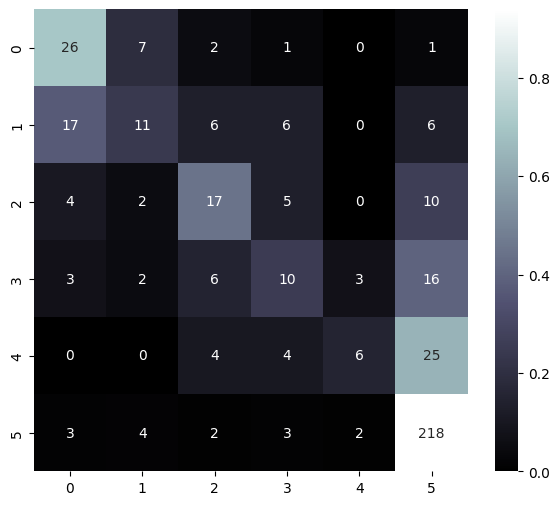

In [90]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = [0,1,2,3,4,5])

In [91]:
# Calculate accuracy
accuracy = model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(mse)

# print(y_pred_proba, y_test)

Accuracy: 66.67%
1.4560185185185186


## Feature importance

In [92]:
# from sklearn.inspection import permutation_importance

# # Calculate permutation feature importance
# result = permutation_importance(
#     model, X_test, y_test, scoring='neg_log_loss', n_repeats=10, random_state=42
# )

# # Get the feature importances and sort them in descending order
# feature_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)


In [93]:
# feature_importances_2 = feature_importances.reset_index()
# feature_importances_2

In [94]:
# feature_importances.to_excel("features2.xlsx")

## Hypertune

In [95]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [96]:
space6 = {'max_depth': hp.quniform("max_depth", 10, 20, 1),
        'gamma': hp.uniform ('gamma', 0.01,1),
        'reg_alpha' : hp.quniform('reg_alpha', 0.2,4,0.2),
        'reg_lambda' : hp.uniform('reg_lambda', 0.1,0.5),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.quniform('min_child_weight', 3, 12, 1),
        'n_estimators' : hp.quniform('n_estimators', 400, 600, 10),
        'learning_rate' : hp.uniform('learning_rate', 0.01, 0.1)}


In [97]:

def objective(space):
    clf = XGBClassifier(
                    n_estimators = int(space['n_estimators']),
                    max_depth=int(space['max_depth']), 
                    gamma=space['gamma'],
                    reg_alpha=int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=space['colsample_bytree'],  # Not cast to int
                    seed=123,
                    objective='multi:softmax',
                    num_class=6,
                    tree_method='hist',
                    learning_rate=space['learning_rate'],
                    subsample=0.8)

    clf.fit(X_train, y_train, verbose=False)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK}


In [98]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space6,
#                         algo = tpe.suggest,
#                         max_evals = 500,
#                         trials = trials)

In [99]:
# best_hyperparams

## Prediction final

In [100]:
prediction_df = pd.read_excel("prediction_df.xlsx", index_col=0)

X_pred = prediction_df.drop(to_remove, axis = 1)
X_pred = X_pred.drop(["surname"], axis = 1)
X_pred = X_pred[X.columns] 

In [101]:
y_pred_proba = model.predict_proba(X_pred)
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns = ["pos_0","pos_1","pos_2","pos_3","pos_4","pos_5"]) 

y_pred_proba_df
y_pred_proba_df["raceId"] = prediction_df["raceId"].values
y_pred_proba_df["surname"] = prediction_df["surname"].values


In [102]:
y_pred_proba_df["rank"] = y_pred_proba_df["pos_0"].apply(lambda x: 1 if x == max(y_pred_proba_df["pos_0"]) else 0)
y_pred_proba_df["rank"] = y_pred_proba_df.apply(lambda x: 2 if x["pos_1"] == max(y_pred_proba_df["pos_1"][y_pred_proba_df["rank"]==0]) else x["rank"], axis = 1)
y_pred_proba_df["rank"] = y_pred_proba_df.apply(lambda x: 3 if x["pos_2"] == max(y_pred_proba_df["pos_2"][y_pred_proba_df["rank"]==0]) else x["rank"], axis = 1)
y_pred_proba_df["rank"] = y_pred_proba_df.apply(lambda x: 4 if x["pos_3"] == max(y_pred_proba_df["pos_3"][y_pred_proba_df["rank"]==0]) else x["rank"], axis = 1)
y_pred_proba_df["rank"] = y_pred_proba_df.apply(lambda x: 5 if x["pos_4"] == max(y_pred_proba_df["pos_4"][y_pred_proba_df["rank"]==0]) else x["rank"], axis = 1)
y_pred_proba_df["rank"] = y_pred_proba_df.apply(lambda x: np.nan if x["rank"]==0 else x["rank"], axis = 1)
y_pred_proba_df.sort_values("rank")
# y_pred_proba_df.to_excel("final_data.xlsx")

,pos_0,pos_1,pos_2,pos_3,pos_4,pos_5,raceId,surname,rank
1,0.751313,0.155612,0.030412,0.028461,0.013857,0.020345,1127,verstappen,1.0
0,0.157442,0.400492,0.119217,0.083911,0.113279,0.125659,1127,norris,2.0
2,0.059692,0.204874,0.255192,0.249250,0.114812,0.116180,1127,leclerc,3.0
4,0.036692,0.099537,0.248695,0.267389,0.212455,0.135233,1127,sainz,4.0
12,0.023471,0.065022,0.098753,0.228026,0.193227,0.391500,1127,piastri,5.0
3,0.214816,0.176551,0.148887,0.175089,0.082603,0.202053,1127,pérez,NaN
5,0.003839,0.016707,0.032438,0.049319,0.059156,0.838542,1127,hamilton,NaN
6,0.002761,0.008022,0.017490,0.024194,0.049594,0.897938,1127,tsunoda,NaN
7,0.009340,0.020985,0.054882,0.052011,0.107443,0.755340,1127,russell,NaN
8,0.004579,0.009670,0.020629,0.017410,0.030479,0.917233,1127,alonso,NaN
